### 3D Computer Vision - Exercise 2
Olivier Kanamugire

January 18, 2025.

## Task 1. Intrinsic calibration (1 point).

In [1]:
import numpy as np

#Principal point
(o_x,o_y) = (320,240) 

# Effective pixel size in meters.
micrometer = 1e-6
(s_x, s_y) = (10 * micrometer, 10 * micrometer)
 
# Focal length in meters.
f = 16 * 1e-3

# Point in camera coordinates.
camera_coord = np.array([1, 0, 8])

# Compute camera frame coordinates (x, y) and pixel coordinates
# Image plane coordinates (in meters) using the following formulas:
# x = f * X / Z
# y = f * Y / Z
x = f * (camera_coord[0] / camera_coord[2])  
y = f * (camera_coord[1] / camera_coord[2])  

# Pixel coordinates
p_x = o_x - (x / s_x)  
p_y = o_y - (y / s_y)  

# Result
p = (p_x, p_y)

# TODO: Print the result
print("The pixel coordinates p of the projection are:", p)


The pixel coordinates p of the projection are: (119.99999999999997, 240.0)


## Task 2. Calibrated projection and weak perspective camera (2 points).

- You can install the `h5pyp`/ package by running `pip3 install h5py` 
- You can install `pyvista` by running `pip3 install pyvista[all]`

In [2]:
#pip install pyvista

In [3]:
import h5py
from plotting_utils import plot_frame, plot_color, plot_color_projection

# Read the file
with h5py.File('task2.mat', 'r') as f:
    print(f.keys())
    # For some reason the values are transposed when read 
    WTC = np.array(f.get("WTC")).T          # 4 x 4
    colors = np.array(f.get("colors")).T    # 3 x 19600
    points = np.array(f.get("points")).T    # 3 x 19600

    # Shift so the minimum becomes 0
    colors = colors - np.min(colors)  

    # Scale so the maximum becomes 1
    colors = colors / np.max(colors)  
    
    assert (WTC[3, :3] == 0).all(), "WTC is transposed"
    

<KeysViewHDF5 ['WTC', 'colors', 'points']>


In [4]:
import pyvista as pv

In [5]:
#pip install trame

c:\Users\olivi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\olivi\AppData\Local\Programs\Python\Python312\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


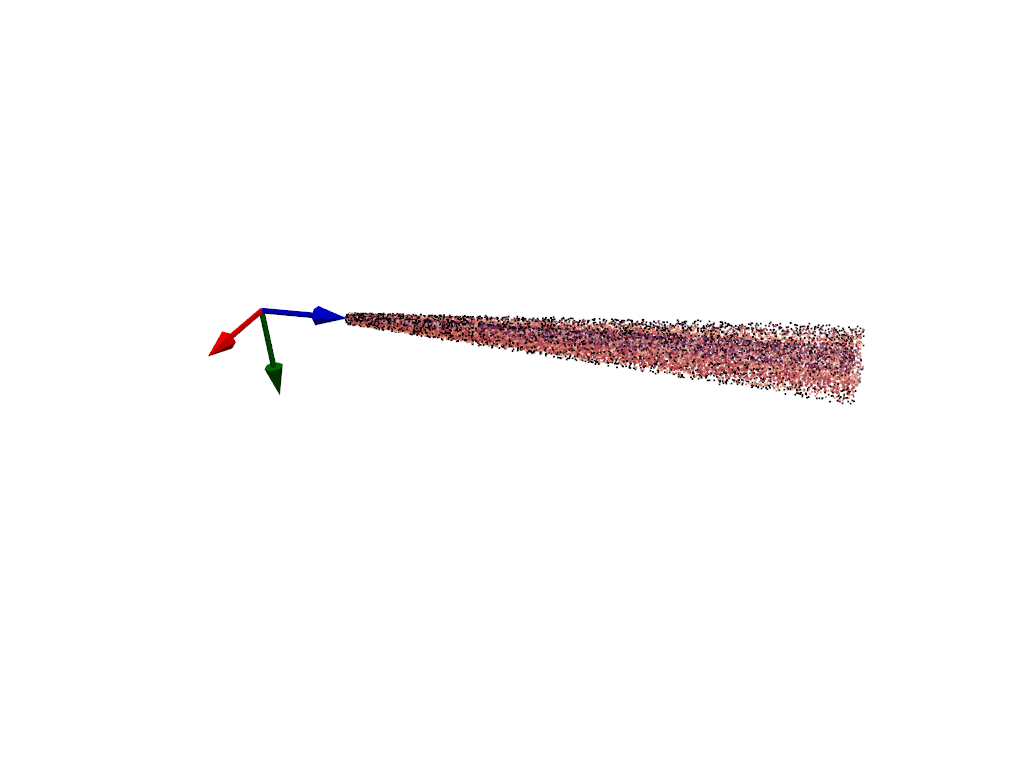

In [6]:
# TODO: Define principal point, effective pixel size, focal length

o_x, o_y = 70,70
micrometer = 1e-6
(s_x, s_y) = (10 * micrometer, 10 * micrometer)
f = 16 * 1e-3

plotter = pv.Plotter()


# a) Plot points and camera frame 
plot_color(plotter, points, colors)  
plot_frame(plotter, WTC)  
plotter.show()

In [12]:
# b) Camera matrix
# Intrinsic camera matrix
K = np.array([
    [f / s_x, 0, o_x],
    [0, f / s_y, o_y],
    [0, 0, 1]
])

# camera-to-world transformation matrix
R = WTC[:3, :3]  # Rotation matrix
t = WTC[:3, 3]   # Translation vector 

# Combine rotation and translation into extrinsic matrix
Rt = np.hstack((R, t.reshape(-1, 1)))

# Projection matrix 
M = K @ Rt
print('The shape of this projection matrix is', M.shape)
print('The projection matrix is', M)


# Project 3D points into the image plane
projected_points = M @ points  

# Normalize homogeneous coordinates to get 2D image coordinates
image_coordinates = projected_points[:2] / projected_points[2]



The shape of this projection matrix is (3, 4)
The projection matrix is [[ 1.47898914e+03 -6.91622137e+01 -6.10497914e+02  1.61400000e+04]
 [ 6.17211942e+02  1.77640106e+02  1.46710375e+03  8.14000000e+03]
 [ 5.98158795e-02 -9.88031624e-01  1.42181470e-01  2.00000000e+00]]


In [13]:
points.shape

(4, 19600)

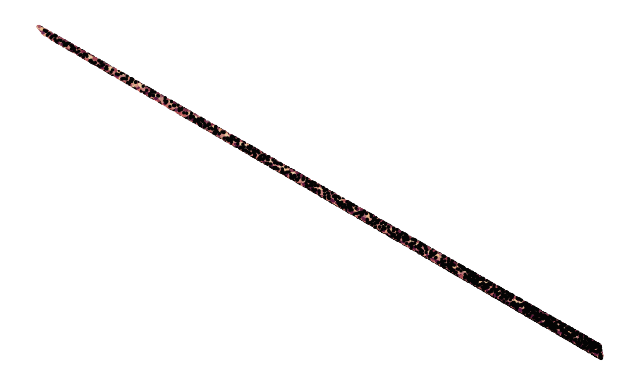

In [14]:
# c) Plot the color projection
plot_color_projection(image_coordinates, colors)

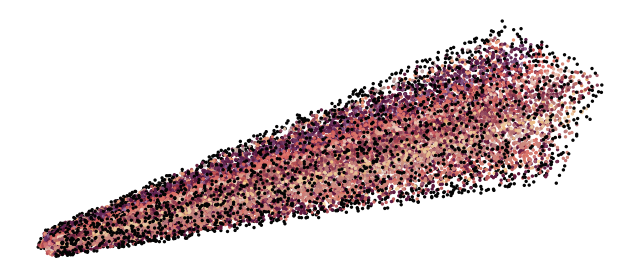

In [19]:
# d) Weak perspective camera

# TODO: Calculate projection matrix, points in projection plane, image coordinates, and plot
# d) Weak perspective camera

# Step 1: Transform points from the world frame to the camera frame using extrinsic parameters
camera_points = WTC @ points
Z_mean = np.mean(camera_points[2, :])  

scaling_factor = f / (s_x * Z_mean)

projected_points_weak = scaling_factor * camera_points[:2, :]  # Scale X and Y

projected_points_weak[0, :] += o_x  
projected_points_weak[1, :] += o_y  

# Step 5: Plot the color projection
plot_color_projection(projected_points_weak, colors)

## Task 3. Projective points (1 point).



Consider a simple camera frame projection matrix (the intrinsic parameters)
$$
\begin{pmatrix}
-f & 0& 0& 0\\
0 & -f& 0 &0 \\
0 &0  &1 &0
\end{pmatrix}
$$
We need to compute the projection of the (homogeneous) point (X, Y,Z,W) = (1, 0, 1, 0) in terms of
f.

$$
\text{Projection} = 
\begin{pmatrix}
-f & 0& 0& 0\\
0 & -f& 0 &0 \\
0 &0  &1 &0
\end{pmatrix}\cdot
\begin{pmatrix}
1\\
0\\
1\\
0
\end{pmatrix} =
\begin{pmatrix}
-f\\
0\\
1
\end{pmatrix}
$$


If we look at the homogeneous coordinate $(−f,0,1)$, we see that it is a point in the image plane at some location (depending on the value of $f$) but with an indeterminate depth. The W-coordinate is 1, which means this is a valid point on the image plane.

The projection is meaningful in the sense that it gives us a point on the image plane. However, since the point $(1,0,1,0)$ is a degenerate homogeneous coordinate (the fourth coordinate is 0), it doesn't represent a valid Euclidean point in 3D space. Instead, it corresponds to a direction, and multiple points along this direction in 3D space will project to the same image point.